In [4]:
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mdates
import numpy as np

In [5]:
#NSE TCS Historical Data Import
infile = 'data/t_data.csv'

df = pd.read_csv(infile, index_col=0, parse_dates=True)

In [6]:
#Parabolic SAR Calculation With High and Low Values
def calculate_psar(high, low, af_start=0.02, af_step=0.02, af_max=0.2):
    psar = []
    trend = []
    af = af_start
    af_direction = 1
    extreme_point = low.iloc[0]
    psar.append(extreme_point)
    trend.append(-1)

    for i in range(1, len(high)):
        if trend[-1] == -1:
            if high.iloc[i] > extreme_point:
                extreme_point = high.iloc[i]
                af = min(af + af_direction * af_step, af_max)
            psar.append(psar[-1] + af * (extreme_point - psar[-1]))
            if psar[-1] > low.iloc[i-1]:
                psar[-1] = low.iloc[i-1]
            if psar[-1] > low.iloc[i]:
                trend.append(1)
                extreme_point = low.iloc[i]
                af = af_start
            else:
                trend.append(-1)
        else:
            if low.iloc[i] < extreme_point:
                extreme_point = low.iloc[i]
                af = min(af + af_direction * af_step, af_max)
            psar.append(psar[-1] + af * (extreme_point - psar[-1]))
            if psar[-1] < high.iloc[i-1]:
                psar[-1] = high.iloc[i-1]
            if psar[-1] < high.iloc[i]:
                trend.append(-1)
                extreme_point = high.iloc[i]
                af = af_start
            else:
                trend.append(1)

    return pd.Series(psar, index=high.index), pd.Series(trend, index=high.index)


In [7]:
#Segregation Positive and Negative Trend
def color(df):
    UP = []
    DOWN = []
    for i in range(len(df)):
        if df['PSAR'][i] < df['Close'][i]:
            UP.append(int(df['PSAR'][i]))
            DOWN.append(np.nan)
        elif df['PSAR'][i] > df['Close'][i]:
            DOWN.append(int(df['PSAR'][i]))
            UP.append(np.nan)
        else:
            UP.append(np.nan)
            DOWN.append(np.nan)
    df['up'] = UP
    df['down'] = DOWN
    return df 

In [8]:
high = df['High']
low = df['Low']

In [9]:
df['PSAR'], df['PSAR_1'] = calculate_psar(high, low, af_start=0.02, af_step=0.02, af_max=0.2)
psar_df = color(df)

In [10]:
a = psar_df[['up']]
b = psar_df[['down']]

In [11]:
psar = [
    mpf.make_addplot(a,scatter=True,color='green',),
    mpf.make_addplot(b,scatter=True,color='red',),
]

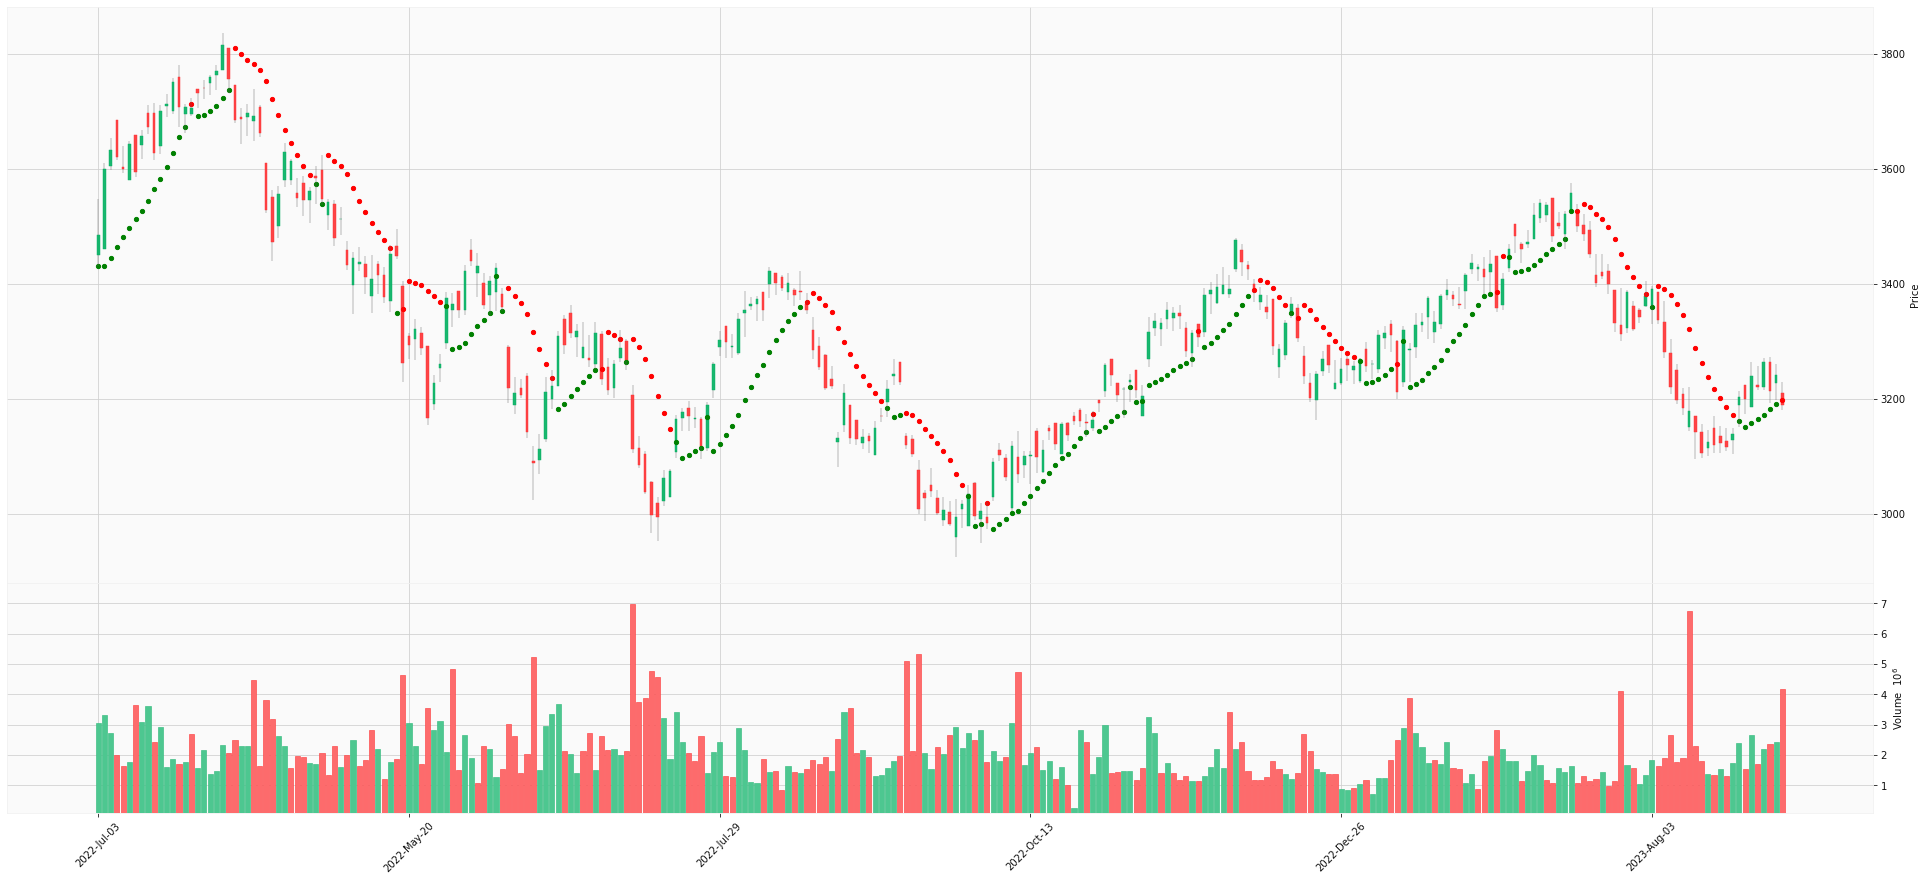

In [12]:
mpf.plot(
    df,
    volume=True,
    type="candle", 
    #fill_between = [ichimoko_fill_up,ichimoko_fill_down],
    style="yahoo",
    addplot=psar,
    figscale=1.2,
    figsize=(36,16,)
)